In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [32]:
mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [33]:
cd ~/.kaggle

/root/.kaggle


In [34]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [35]:
cd /content/gdrive/MyDrive/Colab Notebooks

/content/gdrive/MyDrive/Colab Notebooks


In [40]:
folderpath = '/content/gdrive/MyDrive/Colab Notebooks/pknu-deep-learning-2024/rowdata/rowdata'

In [41]:
import random
import tensorflow as tf
seed_num = 71
random.seed(seed_num)

In [42]:
import numpy as np
import os


# 파라미터로 학습 및 테스트 폴더의 모든 서명 데이터를 읽고
#전체 서명의 길이 중 가장 긴 길이의 값을 반환
def get_max_len(folderpath_train, folderpath_test):
  n_max_len = 0
  for filename in os.listdir(folderpath_train):
    filepath = f'{folderpath_train}/{filename}'
    d, tmp = load_a_sig(filepath)
    if d.shape[0] > n_max_len:
      n_max_len = d.shape[0]

  for filename in os.listdir(folderpath_test):
    filepath = f'{folderpath_test}/{filename}'
    d,tmp = load_a_sig(filepath)
    if d.shape[0] > n_max_len:
      n_max_len = d.shape[0]

  return n_max_len

# 파라미터로 주어진 폴더에 들어 있는 서명 파일 전체를 읽고,
#n_files * n_max_len * 2 크기의 numpy 배열로 만들어 반환
# 파라미터 n_max_len은 전체 서명 데이터들 중 가장 긴 서며야의 길이를 의미

# 데이터와 함께 반환하는 len_sign 는 각 서명의 실제 길이를 의미

def load_data(folderpath, n_max_len, sig_ids):
  filelist = os.listdir(folderpath)
  n_files = len(filelist)
  d = np.zeros((n_files, n_max_len,2))

  len_sign = np.zeros(n_files)

  for i in sig_ids:
    filepath = f'{folderpath}/{i}.TXT'
    d_tmp, len_sign[i-sig_ids[0]] = load_a_sig(filepath)

    d[i-sig_ids[0],:d_tmp.shape[0],:] = d_tmp
  return d,len_sign


# 파라미터로 주어진 서명 파일을 읽고, nPoint * 2 크기의 numpy 배열로 만들어 반환

def load_a_sig(filepath):
  f = open(filepath,'rt')
  nPoints = int(f.readline())

  d = np.zeros((nPoints,2))
  for i in range(nPoints):
    line = f.readline()
    toks = line.split(' ')
    d[i,:] = [int(toks[0]), int(toks[1])]
  f.close()
  return d, nPoints

In [43]:
n_train = 800
n_test = 800

n_max_len = get_max_len(f'{folderpath}/Train', f'{folderpath}/Test')

x_train, x_train_len = load_data(f'{folderpath}/Train', n_max_len,range(n_train))

x_test, x_test_len = load_data(f'{folderpath}/Test', n_max_len, range(n_train,1600))

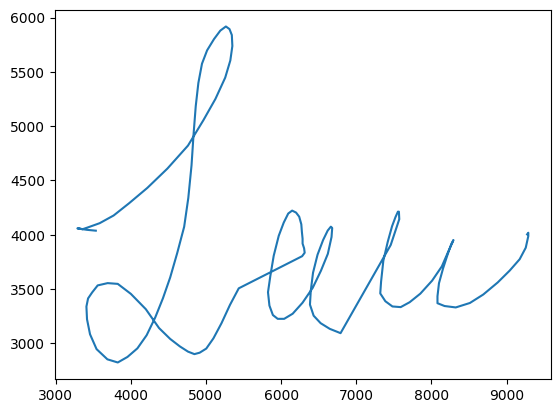

In [44]:
import matplotlib.pyplot as plt
s_id = 10
len_sig = int(x_train_len[s_id])
plt.plot(x_train[s_id,:len_sig,0], x_train[s_id, :len_sig,1])

In [45]:
for i in range(x_train.shape[0]):
  len_tmp = int(x_train_len[i])
  h_min = np.min(x_train[i,:len_tmp,0])
  h_max = np.max(x_train[i,:len_tmp,0])
  v_min = np.min(x_train[i,:len_tmp,1])
  v_max = np.max(x_train[i,:len_tmp,1])
  w_h_ratio = (v_max - v_min) / (h_max - h_min)
  x_train[i,:len_tmp,0] = (x_train[i,:len_tmp,0] - h_min) / (h_max - h_min)
  x_train[i,:len_tmp,1] = (x_train[i,:len_tmp,1] - v_min) / (v_max - v_min) * w_h_ratio

for i in range(x_test.shape[0]):
  len_tmp = int(x_test_len[i])
  h_min = np.min(x_test[i,:len_tmp,0])
  h_max = np.max(x_test[i,:len_tmp,0])
  v_min = np.min(x_test[i,:len_tmp,1])
  v_max = np.max(x_test[i,:len_tmp,1])

  w_h_ratio = (v_max - v_min) / (h_max - h_min)

  x_test[i,:len_tmp,0] = (x_test[i,:len_tmp,0] - h_min) / (h_max - h_min)
  x_test[i,:len_tmp,1] = (x_test[i,:len_tmp,1] - v_min) / (v_max - v_min) * w_h_ratio


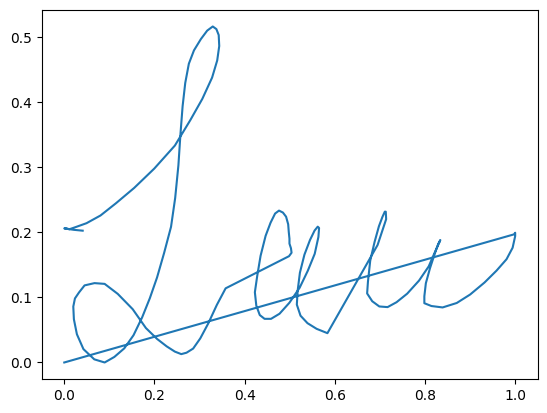

In [46]:
import matplotlib.pyplot as plt
s_id = 10
plt.plot(x_train[s_id,:,0],x_train[s_id,:,1])

In [47]:
import pandas as pd
from tensorflow import keras

y_pd = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/pknu-deep-learning-2024/train_info.csv')
y_all = np.array(y_pd['bGenuine'])
y_train = y_all[:n_train]
y_train_cat = keras.utils.to_categorical(y_train)
# y_test = y_all[:n_train]


In [50]:
import numpy as np
import os
import random
import tensorflow as tf
from sklearn.utils import shuffle
from keras.layers import *
from keras.models import Model
from keras import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.regularizers import l2

seed_num = 71
random.seed(seed_num)
tf.random.set_seed(seed_num)



# Ensure data is shuffled
x_train, y_train_cat = shuffle(x_train, y_train_cat, random_state=seed_num)

# Define a function to reduce the learning rate at specific intervals
def lr_schedule(epoch):
    lr = 0.001
    if epoch > 200:
        lr *= 0.5e-3
    elif epoch > 150:
        lr *= 1e-3
    elif epoch > 100:
        lr *= 1e-2
    elif epoch > 50:
        lr *= 1e-1
    return lr

# Modify the model architecture
model = Sequential()
model.add(Conv1D(64, kernel_size=7, padding='same', activation='relu', kernel_regularizer=l2(0.001), input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(BatchNormalization())
model.add(Conv1D(64, kernel_size=7, padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides=2))

model.add(Conv1D(128, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv1D(128, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides=2))

model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides=2))

model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))))
model.add(Bidirectional(LSTM(64, kernel_regularizer=l2(0.001))))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(units=2, activation='softmax', kernel_regularizer=l2(0.001)))

optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Adding ModelCheckpoint and LearningRateScheduler callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

# Fit the model
hist = model.fit(x=x_train, y=y_train_cat, epochs=300, validation_split=0.3, batch_size=32, callbacks=[checkpoint, reduce_lr])


Epoch 1/300
18/18 [==============================] - ETA: 0s - loss: 2.9450 - accuracy: 0.4768
Epoch 1: val_accuracy improved from -inf to 0.52917, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 18s 216ms/step - loss: 2.9450 - accuracy: 0.4768 - val_loss: 2.8115 - val_accuracy: 0.5292 - lr: 0.0010
Epoch 2/300
18/18 [==============================] - ETA: 0s - loss: 2.7631 - accuracy: 0.5411
Epoch 2: val_accuracy did not improve from 0.52917
18/18 [==============================] - 1s 57ms/step - loss: 2.7631 - accuracy: 0.5411 - val_loss: 2.6735 - val_accuracy: 0.5208 - lr: 0.0010
Epoch 3/300
18/18 [==============================] - ETA: 0s - loss: 2.6305 - accuracy: 0.5214
Epoch 3: val_accuracy did not improve from 0.52917
18/18 [==============================] - 1s 54ms/step - loss: 2.6305 - accuracy: 0.5214 - val_loss: 2.5347 - val_accuracy: 0.5208 - lr: 0.0010
Epoch 4/300
17/18 [===========================>..] - ETA: 0s - loss: 2.4681 - accuracy: 0.5423
Epoch 4: val_accuracy did not improve from 0.52917
18/18 [==============================] - 1s 57ms/step - loss: 2.4703 - accuracy: 0.5411 - val_loss: 2.4126 - val_accuracy: 0.5208 -

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

def drawHistory(hist) :

  # hist.history를 데이터프레임으로 변환
  history_df = pd.DataFrame(hist.history)

  # 데이터프레임을 표로 출력
  print(history_df)

  # 데이터프레임을 시각화 (옵션)
  plt.figure(figsize=(12, 6))

  # 훈련 손실과 검증 손실 그래프
  plt.subplot(1, 2, 1)
  plt.plot(history_df['loss'], label='Training Loss')
  plt.plot(history_df['val_loss'], label='Validation Loss')
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  # 훈련 정확도와 검증 정확도 그래프
  plt.subplot(1, 2, 2)
  plt.plot(history_df['accuracy'], label='Training Accuracy')
  plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

plt.show()



         loss  accuracy  val_loss  val_accuracy        lr
0    2.945026  0.476786  2.811540      0.529167  0.001000
1    2.763090  0.541071  2.673469      0.520833  0.001000
2    2.630482  0.521429  2.534728      0.520833  0.001000
3    2.470266  0.541071  2.412555      0.520833  0.001000
4    2.358133  0.525000  2.284027      0.520833  0.001000
..        ...       ...       ...           ...       ...
295  0.248560  1.000000  0.843665      0.891667  0.000001
296  0.248486  1.000000  0.843891      0.891667  0.000001
297  0.248326  1.000000  0.843220      0.891667  0.000001
298  0.248674  1.000000  0.843991      0.891667  0.000001
299  0.248449  1.000000  0.844265      0.891667  0.000001

[300 rows x 5 columns]


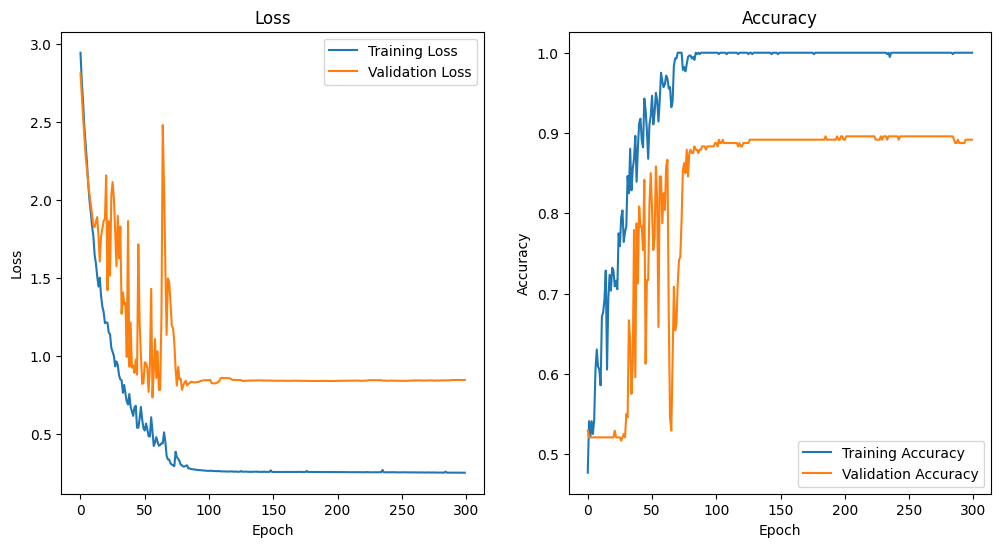

In [52]:
drawHistory(hist)

In [53]:
o = model.predict(x_test)

25/25 [==============================] - 2s 17ms/step


In [54]:
o = np.argmax(o,1)

In [55]:
df = pd.DataFrame(o)
df.columns = ['bGenuine']
df.index = range(800, 800+len(df))
df.index.name = 'num'
print(df)
df.to_csv('test_predict.csv')

      bGenuine
num           
800          1
801          1
802          1
803          0
804          0
...        ...
1595         0
1596         1
1597         0
1598         0
1599         1

[800 rows x 1 columns]


In [56]:
!kaggle competitions submit -c pknu-deep-learning-2024 -f test_predict.csv -m "Message"

100% 5.29k/5.29k [00:00<00:00, 8.04kB/s]
Successfully submitted to PKNU-Deep Learning-2024

In [95]:
cp finalPro

total 13103
-rw------- 1 root root     4399 Mar 12 07:03 202130453_장홍준_2주차_실습_과제.ipynb
-rw------- 1 root root 13093600 Jun 13 04:57 best_model.h5
-rw------- 1 root root   299205 Jun 13 05:14 finalProject.ipynb
drwx------ 3 root root     4096 Jun 11 05:10 pknu-deep-learning-2024/
-rw------- 1 root root     5413 Jun 13 05:00 test_predict.csv
-rw------- 1 root root     9282 Mar 12 05:51 Untitled0.ipynb


In [94]:
cd colab_repo_for_deep_learning

[Errno 2] No such file or directory: 'colab_repo_for_deep_learning'
/content/gdrive/MyDrive/Colab Notebooks


In [88]:
!git config --global user.email "wkdghdwns199@naver.com"

In [89]:
!git config --global user.name "Jang Hong Joon"

In [90]:
!git add *

In [91]:
!git commit -m "commit"

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [92]:
!git push origin main

Everything up-to-date


In [93]:
cd /content/gdrive/MyDrive/Colab\ Notebooks

/content/gdrive/MyDrive/Colab Notebooks
